In [1]:
# pytorch로 합성곱 신경망 모델 훈련

# 데이터 준비
from torchvision.datasets import FashionMNIST

fm_train = FashionMNIST(root='.', train=True, download=True)
fm_test = FashionMNIST(root='.', train=False, download=True)

train_input = fm_train.data
train_target = fm_train.targets
train_scaled = train_input.reshape(-1,1,28,28) / 255.0

from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [6]:
# add_module() 매서드를 사용해 층을 하나씩 추가하는 방법(층이름, 층객체)

# 합성곱층과 렐루활성화함수, 풀링층 추가
import torch
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(1,32,kernel_size=3,padding='same')) # (채널개수,필터개수,커널크기,패딩)
model.add_module('relu', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))

# 두번째 합성곱층 추가 및 Flatten층 추가
model.add_module('conv2', nn.Conv2d(32,64,kernel_size=3,padding='same'))
model.add_module('relu', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))
model.add_module('flatten', nn.Flatten())

In [7]:
# Linear층을 사용할 때 입력 크기를 첫 번째 매개변수로 전달해야하므로, Flatten 층으로 펼친 입력의 크기를 알아야함
# 가짜 입력을 만들어 어떤 크기의 출력이 만들어지는지 확인
outputs = model(torch.ones(1,1,28,28))
print(outputs.shape)

torch.Size([1, 3136])


In [8]:
# 출력층
model.add_module('dense1', nn.Linear(3136, 100))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.3))
model.add_module('dense2', nn.Linear(100,10))

In [9]:
# GPU로 모델 전달 및 손실 함수와 옵티마이저 준비
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [11]:
# TensorDataset 클래스를 사용하여 배치 생성(배치크기 및 shuffle 여부)
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_scaled, train_target)
val_dataset = TensorDataset(val_scaled, val_target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
# 모델 훈련코드 작성
train_hist = []
val_hist = []
patience = 2
best_loss = -1
early_stopping_counter = 0

epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # 검증 손실 계산
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    # 평균 훈련손실과 평균 검증 손실 계산 (데이터로더에 len()함수를 적용하면 배치 반복 횟수 반환)
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f"에포크:{epoch+1},",f"훈련 손실:{train_loss:.4f}, 검증 손실:{val_loss:.4f}") # 에포크 손실 출력

    # 조기 종료
    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        early_stopping_counter += 1
    if early_stopping_counter >= patience:
        print(f"{epoch+1}번쨰 에포크에서 조기 종료되었습니다.")
        break

에포크:1, 훈련 손실:0.4925, 검증 손실:0.3324
에포크:2, 훈련 손실:0.3318, 검증 손실:0.2815
에포크:3, 훈련 손실:0.2855, 검증 손실:0.2655
에포크:4, 훈련 손실:0.2543, 검증 손실:0.2603
에포크:5, 훈련 손실:0.2292, 검증 손실:0.2378
에포크:6, 훈련 손실:0.2073, 검증 손실:0.2371
에포크:7, 훈련 손실:0.1898, 검증 손실:0.2303
에포크:8, 훈련 손실:0.1708, 검증 손실:0.2442
에포크:9, 훈련 손실:0.1573, 검증 손실:0.2556
9번쨰 에포크에서 조기 종료되었습니다.


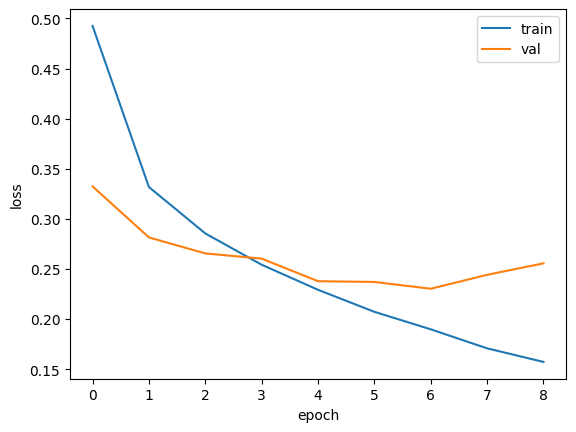

In [13]:
# 훈련손실, 검증손실 그래프
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 'best_model.pt'을 다시 로드하여 검증세트에 대한 정확도 확인
model.load_state_dict(torch.load('best_model.pt', weights_only=True))

model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = torch.argmax(outputs, 1)
        corrects += (predicts == targets).sum().item()

accuracy = corrects / len(val_dataset)
print(f"검증정확도: {accuracy:.4f}")

검증정확도: 0.9177


In [17]:
# 훈련 세트에 대한 정확도 계산

# 데이터 준비
test_scaled = fm_test.data.reshape(-1,1,28,28) / 255.0
test_target = fm_test.targets

test_dataset = TensorDataset(test_scaled, test_target)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# 정확도 계산
model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = torch.argmax(outputs, 1)
        corrects += (predicts == targets).sum().item()

accuracy = corrects / len(test_dataset)
print(f"검증정확도: {accuracy:.4f}")

검증정확도: 0.9132
